# ROB 498-004/599-004 Assignment 3-2: Two-Stage Object Detector - Faster R-CNN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Anthony OPIPARI, #12345678

**Your Answer:**   
Firstname Lastname, #UMID

# Faster R-CNN: A Classic Two-Stage Anchor-Based Object Detector

In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules - Region Proposal Networks (RPN) and Fast R-CNN.
We will train it to detect a set of object classes and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
running_colab = 'google.colab' in str(get_ipython())

if running_colab:
    from google.colab import drive
    print('Running on Colab')
    drive.mount('/content/drive/', force_remount=True)
else:
    print('Running locally')

Running locally


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
["convolutional_networks.ipynb", "two_stage_detector_faster_rcnn.ipynb", "rob599", "convolutional_networks.py", "two_stage_detector.py"]
```

In [5]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2025WN folder and put all the files under P3 folder, then "2025WN/P3"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025WN/P3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './'
GOOGLE_DRIVE_PATH = GOOGLE_DRIVE_PATH_AFTER_MYDRIVE 
#os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['one_minute_deepconvnet.pth', 'convolutional_networks.ipynb', '__pycache__', 'rob599', 'convolutional_networks.py', 'overfit_deepconvnet.pth', 'Progress-Objects-Sample', 'Progress-Objects-Sample.tar.gz', 'two_stage_detector.py', 'two_stage_detector.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from two_stage_detector.py!
Hello from p3_helper.py!
```

as well as the last edit time for the file `two_stage_detector.py`.

In [6]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from two_stage_detector import hello_two_stage_detector
from rob599.p3_helper import hello_helper


hello_two_stage_detector()
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, "two_stage_detector.py")
two_stage_detector_edit_time = time.ctime(
    os.path.getmtime(two_stage_detector_path)
)
print("two_stage_detector.py last edited on %s" % two_stage_detector_edit_time)

Hello from two_stage_detector.py!
Hello from p3_helper.py!
two_stage_detector.py last edited on Tue Jan  1 00:00:00 1980


Load several useful packages that are used in this notebook:

In [7]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from rob599.p3_helper import *
from rob599 import reset_seed
from rob599.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# To download the dataset
!pip install wget

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=c1d0ba6354f901501530ae9653674464a52943209529c1f0228c0d71230373ad
  Stored in directory: /home/mirrorlab/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 908 (delta 135), reused 125 (delta 125), pack-reused 758 (from 1)
Receiving objects: 100% (908/908), 14.70 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (329/329), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [8]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## Load PROPS Detection Dataset
During the majority of our homework assignments so far, we have used the PROPS Classification dataset for image classification tasks.

In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PROPS Detection](https://deeprob.org/datasets/props-detection/) dataset, which provides annotations of this form. This dataset is inspired in part on the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.
The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection.
Our PROPS Detection dataset is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.
PROPS comprises annotated bounding boxes for 10 object classes:
`["master_chef_can", "cracker_box", "sugar_box", "tomato_soup_can", "mustard_bottle", "tuna_fish_can", "gelatin_box", "potted_meat_can", "mug", "large_marker"]`.
The choice of these objects is inspired by the [YCB object and Model set](https://ieeexplore.ieee.org/document/7251504) commonly used in robotic perception models.

We create a [`PyTorch Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class
named `PROPSDetectionDataset` in `p3_helper.py` that will download the PROPS Detection dataset.
This class returns annotations for each image as a nested set of dictionary objects.

Run the following two cells to set a few config parameters and then download the train/val sets for the PROPS Detection dataset.

In [13]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 10
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()

In [15]:
from rob599.p3_helper import PROPSDetectionDataset

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually.
train_dataset = PROPSDetectionDataset(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)
val_dataset = PROPSDetectionDataset(GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0])

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (2500), val (2500)


Now we wrap these dataset objects with PyTorch dataloaders. The format of output batches will also be same as what you have seen before:

In [16]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = next(train_loader_iter)

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['./PROPS-Detection-Dataset/PROPS-Detection/000000.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000001.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000002.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000003.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000004.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000005.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000006.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000007.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000008.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000009.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000010.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000011.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000012.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000013.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000014.jpg', './PROPS-Detection-Dataset/PROPS-Detection/000015.jpg']
image batch has shape : torch.Size([16, 3, 224, 224])
gt_boxes has shape    : t

## Visualize PROPS Detection

We will visualize a few images and their GT boxes, just to make sure that everything is loaded properly. After running the following cell, you should see output consisting of three images plotted with the corresponding object bounding boxes for each visible class.

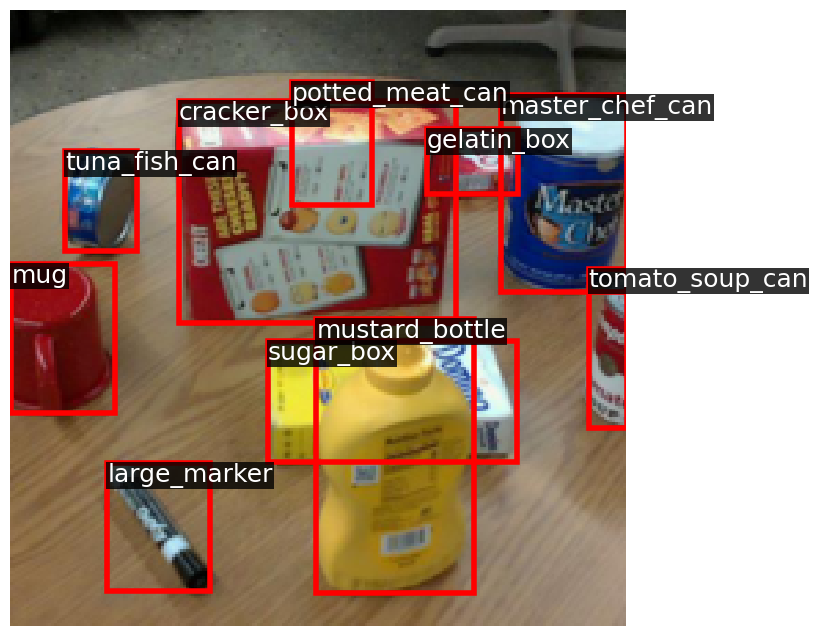

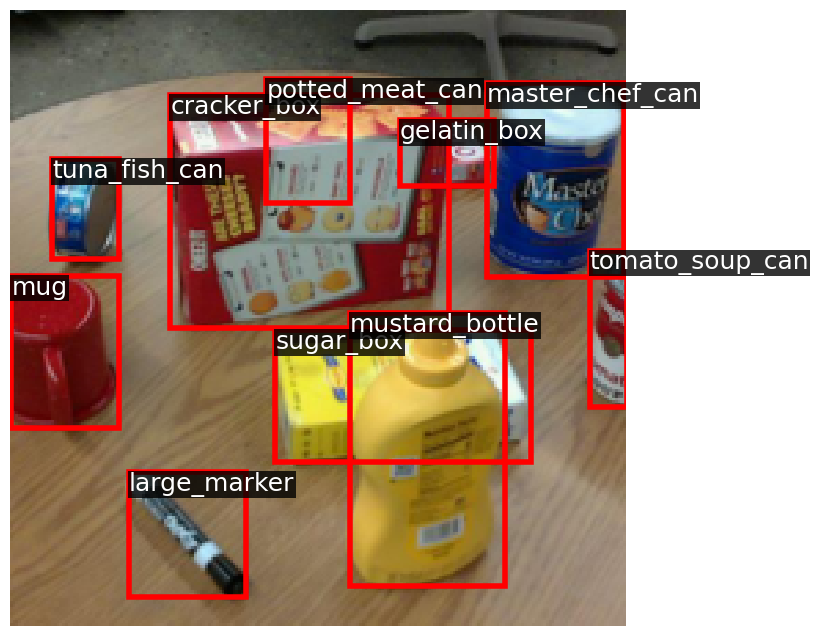

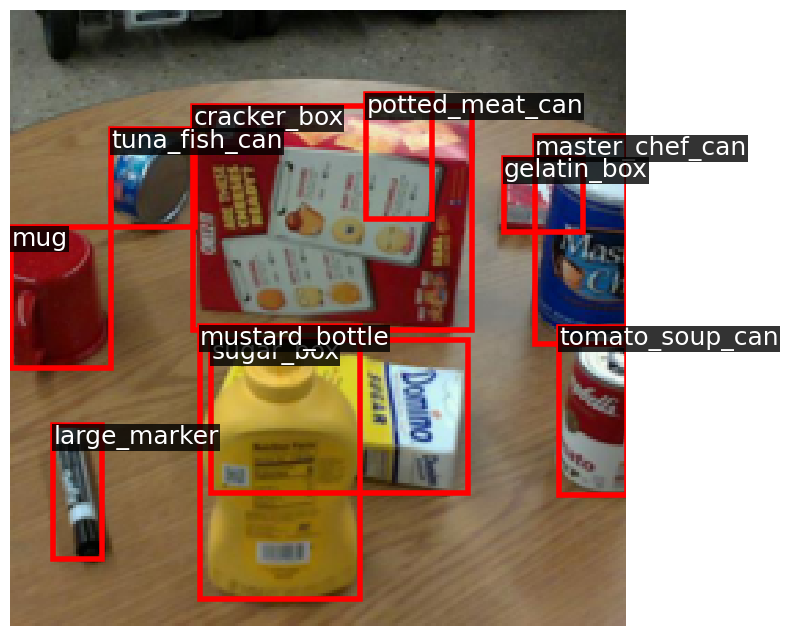

In [17]:
from torchvision import transforms
from rob599.utils import detection_visualizer

inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    if idx > 2:
        break

    image = inverse_norm(image)
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

## Implementing Backbone and Feature Pyramid Network

First, we start building the backbone and FPN of our detector. It is the core component that takes in an image and outputs features of different scales. It can be any type of convolutional network that progressively downsamples the image (e.g. via intermediate max pooling).

Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. We have already implemented the minimal logic to initialize this backbone from pre-trained ImageNet weights and extract intermediate features `(c3, c4, c5)`.
These features `(c3, c4, c5)` have height and width that is ${1/8}^{th}$, ${1/16}^{th}$, and ${1/32}^{th}$ of the input image respectively.
These values `(8, 16, 32)` are called the "stride" of these features.
In other words, it means that moving one location on the FPN level is equivalent to moving `stride` pixels in the input image.

FPN will convert these `(c3, c4, c5)` multi-scale features to `(p3, p4, p5)`. These notations "p3", "p4", "p5" are called _FPN levels_.
Before you write any code, let's initialize the backbone in the next cell. You should see the shape of `(c3, c4, c5)` features for an input image:

In [32]:
import torch
from two_stage_detector import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


Follow the instructions in `two_stage_detector.py` to implement additional FPN layers in the `DetectorBackboneWithFPN` class for transforming `(c3, c4, c5)` to `(p3, p4, p5)`.
For training a small enough model on Google Colab, we leave out `(p6, p7)`.
Output features from these FPN levels are expected to have same height and width as backbone features, but now they should have the same number of channels.

In [34]:
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

Extra FPN modules added:
ModuleDict(
  (lateral_c3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (lateral_c4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (lateral_c5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (p3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])


## Faster R-CNN first stage: Region Proposal Network (RPN)

We will now implement the first-stage of Faster R-CNN. It comprises a **Region Proposal Network (RPN)** that learns to predict general _object proposals_, which will then be used by the second stage to make final predictions.

**RPN prediction:** An input image is passed through the backbone and we obtain its FPN feature maps `(p3, p4, p5)`.
The RPN predicts multiple values at _every location on FPN features_. Faster R-CNN is _anchor-based_ — the model assumes that every location has multiple pre-defined boxes (called "anchors") and it predicts two measures per anchor, per FPN location:

1. **Objectness:** The likelihood of having _any_ object inside the anchor. This is _class-agnostic_: it only performs binary foreground/background classification.
2. **Box regression deltas:** 4-D "deltas" that _transform_ an anchor at that location to a ground-truth box.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

**SIDE NOTE:** We will use the more common practice of predicting `k` logits and use a logistic regressor instead of `2k` scores (and 2-way softmax) as shown in the above Figure. This slightly reduces the number of trainable parameters.

Now follow the instructions in `RPNPredictionNetwork` of `two_stage_detector.py` and implement layers to predict objectness and box regression deltas.
Execute the following cell to test your implementation:

In [ ]:
from two_stage_detector import RPNPredictionNetwork


rpn_pred_net = RPNPredictionNetwork(
    in_channels=64, stem_channels=[64], num_anchors=3
)

# Pass the dummy FPN feats to RPN prediction network and view its output shapes.
dummy_rpn_obj, dummy_rpn_box = rpn_pred_net(dummy_fpn_feats)

# Few expected outputs:
# Shape of p4 RPN objectness: torch.Size([2, 196, 3])
# Shape of p5 RPN box deltas: torch.Size([2, 49, 12])

print(f"\nFor dummy input images with shape: {dummy_images.shape}")
for level_name in dummy_fpn_feats.keys():
    print(f"Shape of {level_name} FPN features  : {dummy_fpn_feats[level_name].shape}")
    print(f"Shape of {level_name} RPN objectness: {dummy_rpn_obj[level_name].shape}")
    print(f"Shape of {level_name} RPN box deltas: {dummy_rpn_box[level_name].shape}")
    print("")

## Assigning a GT target to every model anchor

Faster R-CNN makes predictions at every anchor.
We need to assign a GT target for each anchor during training. So we can view this problem as assigning GT boxes (and their class labels) to every FPN feature map location.

GT boxes are available (from the dataloader) as 5D vectors `(x1, y1, x2, y2, C)` where `(x1, y1)` is the top-left co-ordinate and `(x2, y2)` is the bottom-right co-ordinate of the bounding box, and `C` is its object class label. These co-ordinates are absolute and real-valued in image dimensions. To begin with the assignment, we will represent every location on an FPN level with `(xc, yc)` absolute and real-valued co-ordinates of a point on the image, that are centers of the receptive fields of those features.

For example, given features from FPN level having shape `(batch_size, channels, H / stride, W / stride)` and the location `feature[:, :, i, j]` will map to the image pixel `(stride * (i + 0.5), stride * (j + 0.5))` - 0.5 indicates the shift from top-left corner to the center of "stride box".

Implement the `get_fpn_location_coords` in `two_stage_detector.py` to get `(xc, yc)` location co-ordinates of all FPN features. Follow its documentation and see its usage example in the following cell:

In [ ]:
from two_stage_detector import get_fpn_location_coords

# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.
expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [4.0, 12.0], [4.0, 20.0], [4.0, 28.0], [4.0, 36.0]]),
    "p4": torch.tensor([[8.0, 8.0], [8.0, 24.0], [8.0, 40.0], [8.0, 56.0], [8.0, 72.0]]),
    "p5": torch.tensor([[16.0, 16.0], [16.0, 48.0], [16.0, 80.0], [16.0, 112.0], [16.0, 144.0]]),
}

print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

## Anchor-based Training of RPN

Now that we implemented this RPN head, our goal is to have it predict _high objectness_ and _accurate box deltas_ for anchors that are likely to contain objects.
We need to assign a target GT box to every RPN prediction for training supervision.

**Faster R-CNN is anchor-based:** instead of _all possible locations_, it makes predictions with reference to some pre-defined _anchor boxes_, and matches each anchor with a single GT box if they have a high enough Intersection-over-Union (IoU).

In the next few cells, we will perform the following steps:

1. **Anchor generation:** Generate a set of anchors for every location in FPN feature map.
2. **Anchor to GT matching:** Match these anchors with GT boxes based on their IoU-overlap.
3. **Format of box deltas:** Implement the tranformation functions to obtain _box deltas_ from GT boxes (model training supervision) and apply deltas to anchors (final proposal boxes for second stage).

Let's approach these steps, one at a time.

### Anchor Generation

Recall that you now have implemented a function to get the absolute image co-ordinates of FPN feature map locations — in `get_fpn_location_coords`.
First we need to form multiple anchor boxes centered at these locations.
RPN defines square anchor boxes of size `scale * stride` at every location, where `stride` is the FPN level stride, and `scale` is a hyperparameter.
For example, anchor boxes for P5 level (`stride = 32`), with `scale = 2` will be boxes of `(64 x 64)` pixels.
RPN also considers anchors of different aspect ratios, apart from square anchor boxes —
follow the instructions in `generate_fpn_anchors` of `two_stage_detector.py` to implement creation of multiple anchor boxes per location.

Execute the next cell to verify your implementation:

In [ ]:
from two_stage_detector import get_fpn_location_coords, generate_fpn_anchors


# Sanity check: Get 2x2 location co-ordinates of p5 (original shape is 7x7).
locations = get_fpn_location_coords(
    shape_per_fpn_level={"p5": (2, 64, 2, 2)}, strides_per_fpn_level={"p5": 32}
)

print("P5 locations:\n", locations["p5"])

# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={"p5": 32},
    stride_scale=2,
    aspect_ratios=[0.5, 1.0, 2.0],
)

print("P5 anchors with different aspect ratios:")
print("P5 1:2 anchors:\n", anchors["p5"][0::3, :], "\n")
# Expected (any ordering is fine):
# [-29.2548,  -6.6274,  61.2548,  38.6274]
# [-29.2548,  25.3726,  61.2548,  70.6274]
# [  2.7452,  -6.6274,  93.2548,  38.6274]
# [  2.7452,  25.3726,  93.2548,  70.6274]

print("P5 1:1 anchors:\n", anchors["p5"][1::3, :], "\n")
# Expected (any ordering is fine):
# [-16., -16.,  48.,  48.]
# [-16.,  16.,  48.,  80.]
# [ 16., -16.,  80.,  48.]
# [ 16.,  16.,  80.,  80.]

print("P5 2:1 anchors:\n", anchors["p5"][2::3, :], "\n")
# Similar to 1:2 anchors, but with flipped co-ordinates

### Matching anchor boxes with GT boxes

We will now match these generated anchors with GT boxes. Faster R-CNN matches some `N` anchor boxes with `M` GT boxes by applying a simple rule:

> Anchor box $N_i$ is matched with box $M_i$ if it has an IoU overlap higher than 0.6 with that box. For multiple such GT boxes, the anchor is assigned with the GT box that has the highest IoU. Note that a single ground-truth box may assign positive labels to multiple anchors.

**NOTE:** _Faster R-CNN uses 0.7 default threshold_ as mentioned in the lecture slides. We use a lower threeshold to increase the number of positive matches for sampling — this helps in speeding up training in a resource constrained setting like Google Colab.

Anchor boxes with `IoU < 0.3` with ALL GT boxes is assigned background GT box `(-1, -1, -1, -1, -1)`. All other anchors with IoU between `(0.3, 0.6)` are considered "neutral" and ignored during training. It is worth noting that the "neutral" Faster R-CNN anchors cause wasted computation, and removing this redundancy would overly complicate our implementation.

We have implemented this matching procedure for you — see `rcnn_match_anchors_to_gt` of `two_stage_detector.py`.
Read its documentation to understand its input/output format.
It serves to define GT targets for model predictions during training.

This function internally requires IoU computation between all anchors and GT boxes — which you have to implement.
Follow the instructions in `two_stage_detector.py` to implement IoU computation, and execute the next cell for a sanity check — you should observe an error of `1e-7` or less

In [ ]:
import torch
from two_stage_detector import iou


boxes1 = torch.Tensor([[10, 10, 90, 90], [20, 20, 40, 40], [60, 60, 80, 80]])
boxes2 = torch.Tensor([[10, 10, 90, 90], [60, 60, 80, 80], [30, 30, 70, 70]])

expected_iou = torch.Tensor(
    [[1.0, 0.0625, 0.25], [0.0625, 0.0, 0.052631579], [0.0625, 1.0, 0.052631579]]
)
result_iou = iou(boxes1, boxes2)

print("Relative error:", rel_error(expected_iou, result_iou))

### Visualizing matched GT boxes

Now we apply our anchor matching function and visualize one GT box with a random matched positive anchor box.
You may try different images by indexing `train_dataset` below,
make sure to try different FPN levels as certain images may not get any matched GT boxes due to their size.

In [ ]:
import random
from two_stage_detector import get_fpn_location_coords, generate_fpn_anchors, rcnn_match_anchors_to_gt


# Sanity check: Match anchors of p3 level with GT boxes of first image
# in the training dataset.
_, image, gt_boxes = train_dataset[0]

FPN_LEVEL = "p3"
FPN_STRIDE = 8
locations = get_fpn_location_coords(
    shape_per_fpn_level={FPN_LEVEL: (2, 64, 224 // FPN_STRIDE, 224 // FPN_STRIDE)},
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE}
)
# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE},
    stride_scale=8,  # Default value used by Faster R-CNN
    aspect_ratios=[0.5, 1.0, 2.0],
)

matched_gt_boxes = rcnn_match_anchors_to_gt(
    anchors[FPN_LEVEL], gt_boxes, iou_thresholds=(0.3, 0.6)
)

# Flatten anchors and matched boxes:
anchors_p4 = anchors[FPN_LEVEL].view(-1, 4)
matched_boxes_p4 = matched_gt_boxes.view(-1, 5)

# Visualize one selected anchor and its matched GT box.
# NOTE: Run this cell multiple times to see different matched anchors. For car
# image, p3/5 will not work because the GT box was already assigned to p4.
fg_idxs_p4 = (matched_boxes_p4[:, 4] > 0).nonzero()
fg_idx = random.choice(fg_idxs_p4)

# Combine both boxes for visualization:
dummy_vis_boxes = [anchors_p4[fg_idx][0], matched_boxes_p4[fg_idx][0]]

print("Unlabeled red box is positive anchor:")
detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=dummy_vis_boxes,
)

### GT Targets for box regression

Now we work on the third and final component needed to train our RPN — we define transformation functions for box regression deltas. You will find these transforms in [Lecture 12](https://deeprob.org/calendar/#lec-12), follow these and implement two functions in `two_stage_detector.py`:

1. `rcnn_get_deltas_from_anchors`: Accepts anchor boxes and GT boxes, and returns deltas. Required for training supervision.
2. `rcnn_apply_deltas_to_anchors`: Accepts predicted deltas and anchor boxes, and returns predicted boxes. Required during inference.

Run the following cell to check your implementation.

In [ ]:
import torch
from two_stage_detector import rcnn_get_deltas_from_anchors, rcnn_apply_deltas_to_anchors

# Three hard-coded anchor boxes and GT boxes that have a fairly high overlap.
# Add a dummy class ID = 1 indicating foreground
input_anchors = torch.Tensor(
    [[20, 40, 80, 90], [10, 10, 50, 50], [120, 100, 200, 200]]
)
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to anchors should give us the same boxes.
_deltas = rcnn_get_deltas_from_anchors(input_anchors, input_boxes)
output_boxes = rcnn_apply_deltas_to_anchors(_deltas, input_anchors)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))

# Another check: deltas for GT class label = -1 should be -1e8
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_anchor = torch.Tensor([[100, 100, 200, 200]])

_deltas = rcnn_get_deltas_from_anchors(input_anchor, background_box)
output_box = rcnn_apply_deltas_to_anchors(_deltas, input_anchor)

print("Background deltas should be all -1e8  :", _deltas)
print("Output box should be -1e8 or lower    :", output_box)

## Loss Functions

With all predictions assigned with GT targets, we will proceed to compute losses for training the RPN. Here, you will use L1 loss for box regression.

**Objectness classification loss:** Focal Loss was proposed in RetinaNet (2017) to deal with heavy class imbalance caused by "background". Faster R-CNN predates this paper — it dealt with class imbalance by randomly sampling roughly equal amount of foreground-background anchors to train RPN. We have implemented a very simple sampling function for you in `sample_rpn_training` function of `two_stage_detector.py` — you may directly use it while you piece all these components (coming up next).

**Total loss** is the sum of both loss components _per sampled anchor_, averaged by total number of foreground + background anchors.

Execute the next cell to quickly recap their usage.

In [ ]:
import torch
from torch.nn import functional as F


# Sanity check: dummy predictions from model - box regression deltas and
# objectness logits for two anchors.
# shape: (batch_size, HWA, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_obj_logits = torch.randn(1, 2, 1)

# Dummy deltas and objectness targets. Let the second box be background.
# Dummy GT boxes (matched with both anchors).
dummy_gt_deltas = torch.randn_like(dummy_pred_boxreg_deltas)
dummy_gt_deltas[:, 1, :] = -1e8

# Background objectness targets should be 0 (not -1), and foreground
# should be 1. Neutral anchors will not occur here due to sampling.
dummy_gt_objectness = torch.Tensor([1, 0])

# Note that loss is not multiplied with 0.25 here:
loss_box = F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background anchors:
loss_box[dummy_gt_deltas == -1e8] *= 0.0
print("Box regression loss (L1):", loss_box)

# Now calculate objectness loss.
loss_obj = F.binary_cross_entropy_with_logits(
    dummy_pred_obj_logits.view(-1), dummy_gt_objectness, reduction="none"
)
print("Objectness loss (BCE):", loss_obj)

## Non-Maximum Suppression (NMS)

The definition of NMS and instructions on how to compute NMS can be found in the lecture slides:
https://deeprob.org/calendar/#lec-12

Implement the `nms` function in `two_stage_detector.py`. We then compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA, and the torchvision implementation will likely be much faster than yours.
This is expected, but your implementation should produce the same outputs as the torchvision version.

This utility will be used for building Faster R-CNN.

In [ ]:
# Perform imports here to make this cell runnble independently,
# students are likely to spend good mount of time here and it is
# best to not require execution of prior cells.
import time
import torch
import torchvision

from two_stage_detector import nms
from rob599 import reset_seed

reset_seed(0)


boxes = (100.0 * torch.rand(5000, 4)).round()
boxes[:, 2] = boxes[:, 2] + boxes[:, 0] + 1.0
boxes[:, 3] = boxes[:, 3] + boxes[:, 1] + 1.0
scores = torch.randn(5000)

names = ["your_cpu", "torchvision_cpu", "torchvision_cuda"]
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.0] * len(names)))
intersects = dict(zip(names[1:], [0.0] * (len(names) - 1)))

for iou_threshold in iou_thresholds:
    tic = time.time()
    my_keep = nms(boxes, scores, iou_threshold)
    elapsed["your_cpu"] += time.time() - tic

    tic = time.time()
    tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    elapsed["torchvision_cpu"] += time.time() - tic
    intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
    intersects["torchvision_cpu"] += intersect

    tic = time.time()
    tv_cuda_keep = torchvision.ops.nms(boxes.to(device=DEVICE), scores.to(device=DEVICE), iou_threshold).to(
        my_keep.device
    )
    torch.cuda.synchronize()
    elapsed["torchvision_cuda"] += time.time() - tic
    intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(
        tv_cuda_keep
    )
    intersects["torchvision_cuda"] += intersect

for key in intersects:
    intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print("Testing NMS:")
print("Your        CPU  implementation: %fs" % elapsed["your_cpu"])
print("torchvision CPU  implementation: %fs" % elapsed["torchvision_cpu"])
print("torchvision CUDA implementation: %fs" % elapsed["torchvision_cuda"])
print("Speedup CPU : %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cpu"]))
print("Speedup CUDA: %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cuda"]))
print(
    "Difference CPU : ", 1.0 - intersects["torchvision_cpu"]
)  # in the order of 1e-3 or less
print(
    "Difference CUDA: ", 1.0 - intersects["torchvision_cuda"]
)  # in the order of 1e-3 or less

## Putting it all together: RPN module

Now you will put together all the things you have implemented into the `RPN` class in `two_stage_detector.py`.
Implement `forward` and `predict_proposals` functions of this module — you have already done most of the heavy lifting, you simply need to call all the functions in a correct way!
Use the previous two cells as a reference to implement loss calculation in `forward()`.

## Overfit small data

In Faster R-CNN, the RPN is trained jointly with the second-stage network.
However, to test our RPN implementation, we will first train just the RPN.
We will use the `train_detector` function. You can read its implementation in `rob599/p3_helper.py`.

The loss should generally do down.

In [ ]:
from torch import nn

from rob599.p3_helper import train_detector
from two_stage_detector import DetectorBackboneWithFPN, RPN

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Create a wrapper module to contain backbone + RPN:
class FirstStage(nn.Module):
    def __init__(self, fpn_channels: int):
        super().__init__()
        self.backbone = DetectorBackboneWithFPN(out_channels=fpn_channels)
        self.rpn = RPN(
            fpn_channels=fpn_channels,
            # Simple stem of two layers:
            stem_channels=[fpn_channels, fpn_channels],
            batch_size_per_image=16,
            anchor_stride_scale=8,
            anchor_aspect_ratios=[0.5, 1.0, 2.0],
            anchor_iou_thresholds=(0.3, 0.6),
        )

    def forward(self, images, gt_boxes=None):
        feats_per_fpn_level = self.backbone(images)
        return self.rpn(feats_per_fpn_level, self.backbone.fpn_strides, gt_boxes)


first_stage = FirstStage(fpn_channels=64).to(DEVICE)

train_detector(
    first_stage,
    small_train_loader,
    learning_rate=8e-3,
    max_iters=1000,
    log_period=20,
    device=DEVICE,
)

# Faster R-CNN

We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given a set of proposal boxes from RPN (per FPN level, per image),
we warp each region from the correspondng map to a fixed size 7x7 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf).
We will use the `roi_align` function from `torchvision`. For usage instructions, see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

For simplicity and computational constraints of Google Colab,
our two-stage detector here differs from a standard Faster R-CNN system in the second stage:
In a full implementation, the second stage of the network would predict a box deltas to further refine RPN proposals.
We omit this for simplicity and keep RPN proposal boxes as final predictions.
Your model will definitely perform better if you add an extra box regression head in second stage.

### Your implementation exercise

Read `FasterRCNN` class documentation and code to understand how everything is pieced together.
By now you have already implemented the core components of a typical object detection system - you have dealt with anchor boxes, matched them with GT boxes, supervised model with your matching, and wrote inference utilities like NMS.
Great work!

### Classification Loss: cross entropy

The classification loss for second-stage is a cross entropy loss — you would have seen this in A3, and it is a multi-class extension of binary cross entropy loss used in RPN objectness classification. You may use `torch.nn.functional.cross_entropy` directly — follow instructions in Python script.

Beyond these, the second stage of Faster R-CNN doesn't add anything that is conceptually new — hence your implementation exercise is fairly lightweight.
We have implemented most of this module for you. We left out a few 3-4 line TODO blocks, only because if we wrote them, they would given away the solution for prior exercises (RPN).
Moreover, empty code blocks will encourage you to carefully read the remaining portions for making everything work.

## Overfit small data

After adding your implementation, overfit the model on a small dataset.

In [ ]:
from two_stage_detector import FasterRCNN


# Re-initialize dataset objects for independent debugging.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

FPN_CHANNELS = 64
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    anchor_stride_scale=8,
    anchor_aspect_ratios=[0.5, 1.0, 2.0],
    anchor_iou_thresholds=(0.3, 0.6),
    pre_nms_topk=400,
    post_nms_topk=80,
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    small_train_loader,
    learning_rate=0.01,
    max_iters=1000,
    log_period=10,
    device=DEVICE,
)

## Inference

Now, follow the instructions in `FasterRCNN.inference` to implement inference.

Visualize the output from the trained model on a few images by executing the next cell, the bounding boxes should be somewhat accurate. They would get even better by using a bigger model and training it for longer.

In [ ]:
from rob599.p3_helper import inference_with_detector


# Change the loader to have (batch size = 1) as required for inference.
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_train_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

## Train a net

Now it's time to train the full Faster R-CNN model on a larger subset of the the training data.
We will train for 9000 iterations; this should take about 2-3 hours on a K80 GPU.
Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!

(Optional) If you train the model longer (e.g., 25K+ iterations), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
from rob599.p3_helper import train_detector
from two_stage_detector import DetectorBackboneWithFPN, RPN, FasterRCNN

reset_seed(0)

# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    pre_nms_topk=500,
    post_nms_topk=200  # Other args from previous cell are default args in RPN.
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    train_loader,
    learning_rate=0.01,
    max_iters=9000,
    log_period=50,
    device=DEVICE,
)

# After you've trained your model, save the weights for submission.
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
torch.save(faster_rcnn.state_dict(), weights_path)

### Inference

VIsualize a few outputs from the full trained model.
These could be improved if we used a larger model, trained for greater duration, and if we included box regression in the second stage.

In [ ]:
# Add some imports to run this cell independently of above few cells
# (you will need to run first few cells at the top)
from rob599.p3_helper import inference_with_detector
from two_stage_detector import RPN, FasterRCNN, DetectorBackboneWithFPN


# Re-initialize so this cell is independent from prior cells.
# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(fpn_channels=FPN_CHANNELS, stem_channels=[FPN_CHANNELS, FPN_CHANNELS], batch_size_per_image=16)
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
faster_rcnn.to(device=DEVICE)

weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
faster_rcnn.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val daataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=20).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

## Evaluation

Evaluate your Faster R-CNN.

In [ ]:
inference_with_detector(
    faster_rcnn,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)
!cd mAP && python main.py

# This script outputs an image containing per-class AP. Display it here:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")

## Verifying notebook cells

Before moving onto the next part of the project, we can verify that no
unexpected cells have been added or removed by **saving this file** then using the following cell:

In [ ]:
from rob599.p3_helper import verify_notebook_cells

notebook_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_stage_detector.ipynb')
verify_notebook_cells(notebook_path, expected_count=61)

# Submit Your Work
After completing both notebooks for this assignment (`convolutional_networks.ipynb` and this notebook, `two_stage_detector.ipynb`), run the following cell to create a `.zip` file for you to download and turn in.

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from rob599.submit import make_p3_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None

make_p3_submission(GOOGLE_DRIVE_PATH, uniquename, umid)

Now you are ready to submit your project to the autograder.